Dimer with Kanamori interaction
=======

We calculate the Green function of a dimer coupled with Kanamori interaction and a coupling to discrete bath states.

The non-interacting hamiltonian is most conveniently expressed using a matrix representation

$$
\hat{h} =
\begin{pmatrix}
\hat{h}_{0} & \hat{h}_{\rm coup} \\
\hat{h}_{\rm coup} & \hat{h}_{\rm bath}  \\
\end{pmatrix}=
\begin{pmatrix}
\begin{pmatrix}
-\mu & 0 \\
0 & -mu
\end{pmatrix} & 
\begin{pmatrix}
t & 0 \\
0 & t
\end{pmatrix}
\\
\begin{pmatrix}
t & 0 \\
0 & t
\end{pmatrix} & 
\begin{pmatrix}
\epsilon_{00} & \epsilon_{01} \\
\epsilon_{10} & \epsilon_{11}
\end{pmatrix}
\end{pmatrix}
$$

The impurity interaction is of the Kanamori-type, and reads (impurity sites denoted by \{0,1\})

$$h_{\rm int} = \sum_{i,j=0}^{1} U n_{\uparrow,i} n_{\downarrow,j} + \sum_{\sigma,i\neq j} U' n_{\sigma,i} n_{\sigma,j}
            - \sum_{i \neq j} J c^\dagger_{i \uparrow} c_{i \downarrow} c^\dagger_{j \downarrow} c_{j \uparrow}
            + \sum_{i \neq j} J c^\dagger_{i \uparrow} c^\dagger_{i \downarrow} c_{j \downarrow} a_{j \uparrow}$$
   
The parameters are defined below.

In [1]:
# %load model.py
execfile('../common/util.py')

from pytriqs.gf import Gf, MeshImFreq, iOmega_n, inverse
from pytriqs.operators import c, c_dag, n
from pytriqs.operators.util.U_matrix import cubic_names, U_matrix
from pytriqs.operators.util.hamiltonians import h_int_slater
from itertools import product
from numpy import matrix, array

# ==== System Parameters ====
beta = 5.           # Inverse temperature
mu = 26.            # Chemical potential
U = 2.              # Density-density interaction for opposite spins
J = 0.5             # Hunds coupling
F0 = U
F2 = J*(14.0/(1.0 + 0.63))
F4 = F2*0.63
U_mat = U_matrix(2,[F0,F2,F4],basis='cubic')
orb_names = list(cubic_names(2))

# Hybridization function parameters
delta_params={"xy"      : {'V':0.2,'e':-0.2},
              "yz"      : {'V':0.2,'e':-0.15},
              "z^2"     : {'V':0.2,'e':-0.1},
              "xz"      : {'V':0.2,'e':0.05},
              "x^2-y^2" : {'V':0.2,'e':0.4}}

atomic_levels = {('up', 'xy')       : -0.2,
                 ('dn', 'xy')       : -0.2,
                 ('up', 'yz')       : -0.15,
                 ('dn', 'yz')       : -0.15,
                 ('up', 'z^2')      : -0.1,
                 ('dn', 'z^2')      : -0.1,
                 ('up', 'xz')       : 0.05,
                 ('dn', 'xz')       : 0.05,
                 ('up', 'x^2-y^2')  : 0.4,
                 ('dn', 'x^2-y^2')  : 0.4}

# ==== Local Hamiltonian ====
# h_0 = ... 

h_int = h_int_slater(['up','dn'], orb_names, U_mat, True)

# h_loc = h_0 + h_int

# ==== Bath & Coupling hamiltonian ====
# h_bath, h_coup = 0, 0
# h_bath = ... 
# h_coup = ... 

# ==== Total impurity hamiltonian and fundamental operators ====
# h_imp = h_loc + h_coup + h_bath
# fundamental_operators = [ c(spin,i) for spin, i in product(['up','dn'],range(4)) ]

# ==== Green function structure ====
gf_struct = [['up', orb_names ], ['dn', orb_names ] ]

# ==== Hybridization Function & Non-Interacting Impurity Green function====
n_iw = 10
iw_mesh = MeshImFreq(beta, 'Fermion', n_iw)
Delta = BlockGf_from_struct(mesh=iw_mesh, struct=gf_struct)
G0_iw = BlockGf_from_struct(mesh=iw_mesh, struct=gf_struct)

G0_iw << inverse(iOmega_n)

for spin, orbital in product(['up','dn'],orb_names):
    V = delta_params[orbital]['V']
    e = delta_params[orbital]['e']

    Delta[spin][orbital,orbital] << (V**2) * inverse(iOmega_n - e)
    G0_iw[spin][orbital,orbital] << inverse(iOmega_n +mu - atomic_levels[(spin,orbital)] - Delta[spin][orbital,orbital])


Results
====

In [2]:
from pytriqs.plot.mpl_interface import oplot, plt
%matplotlib inline

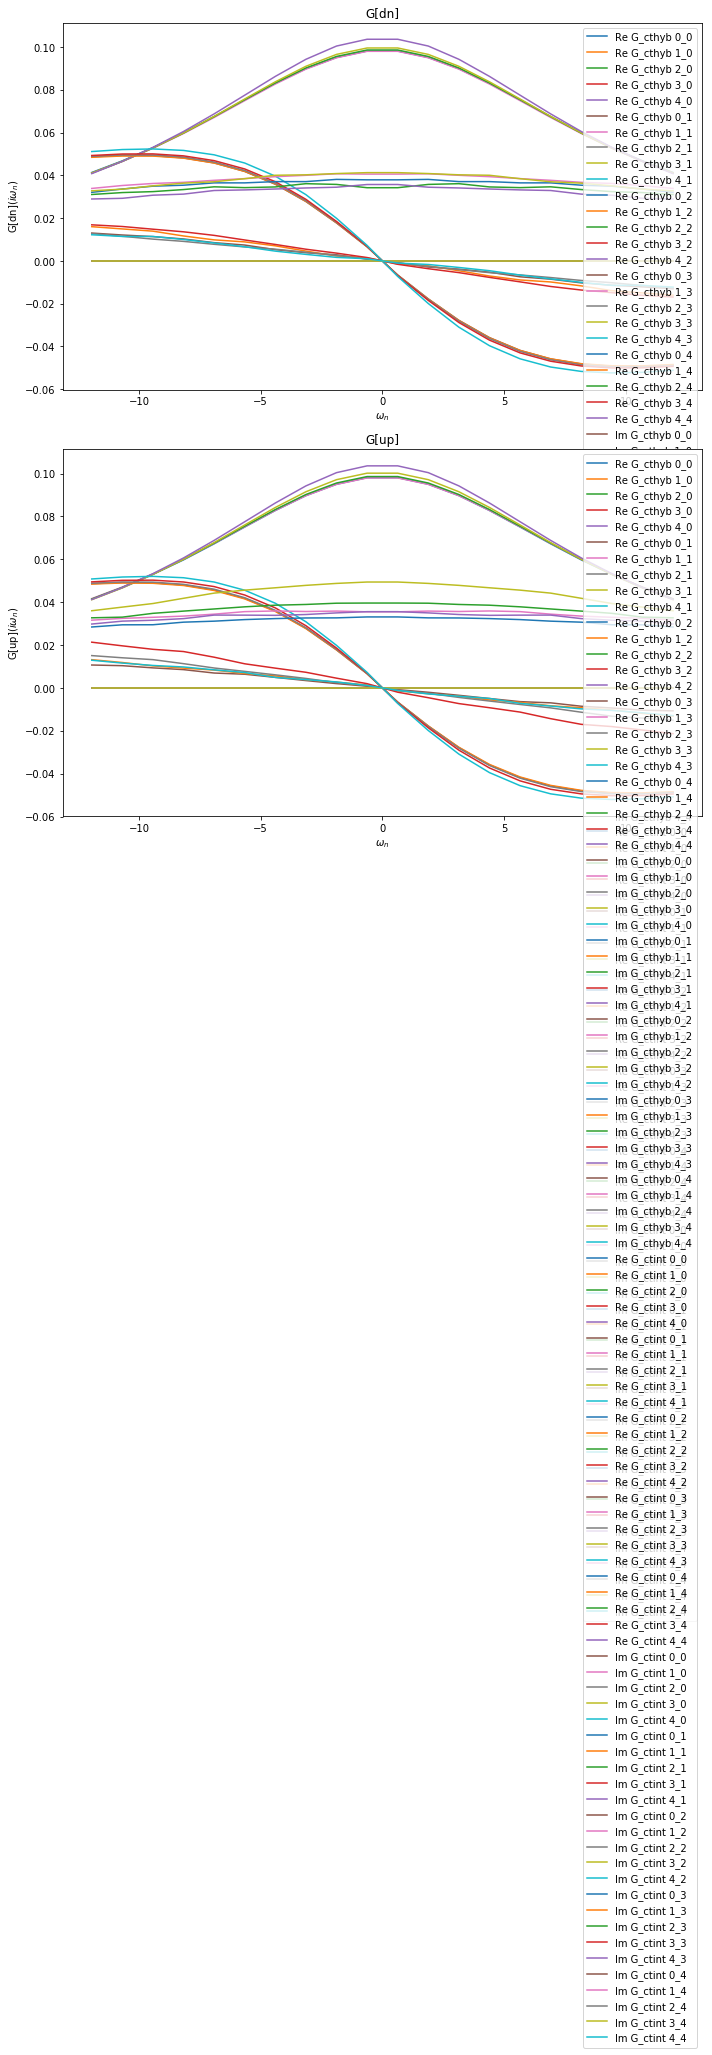

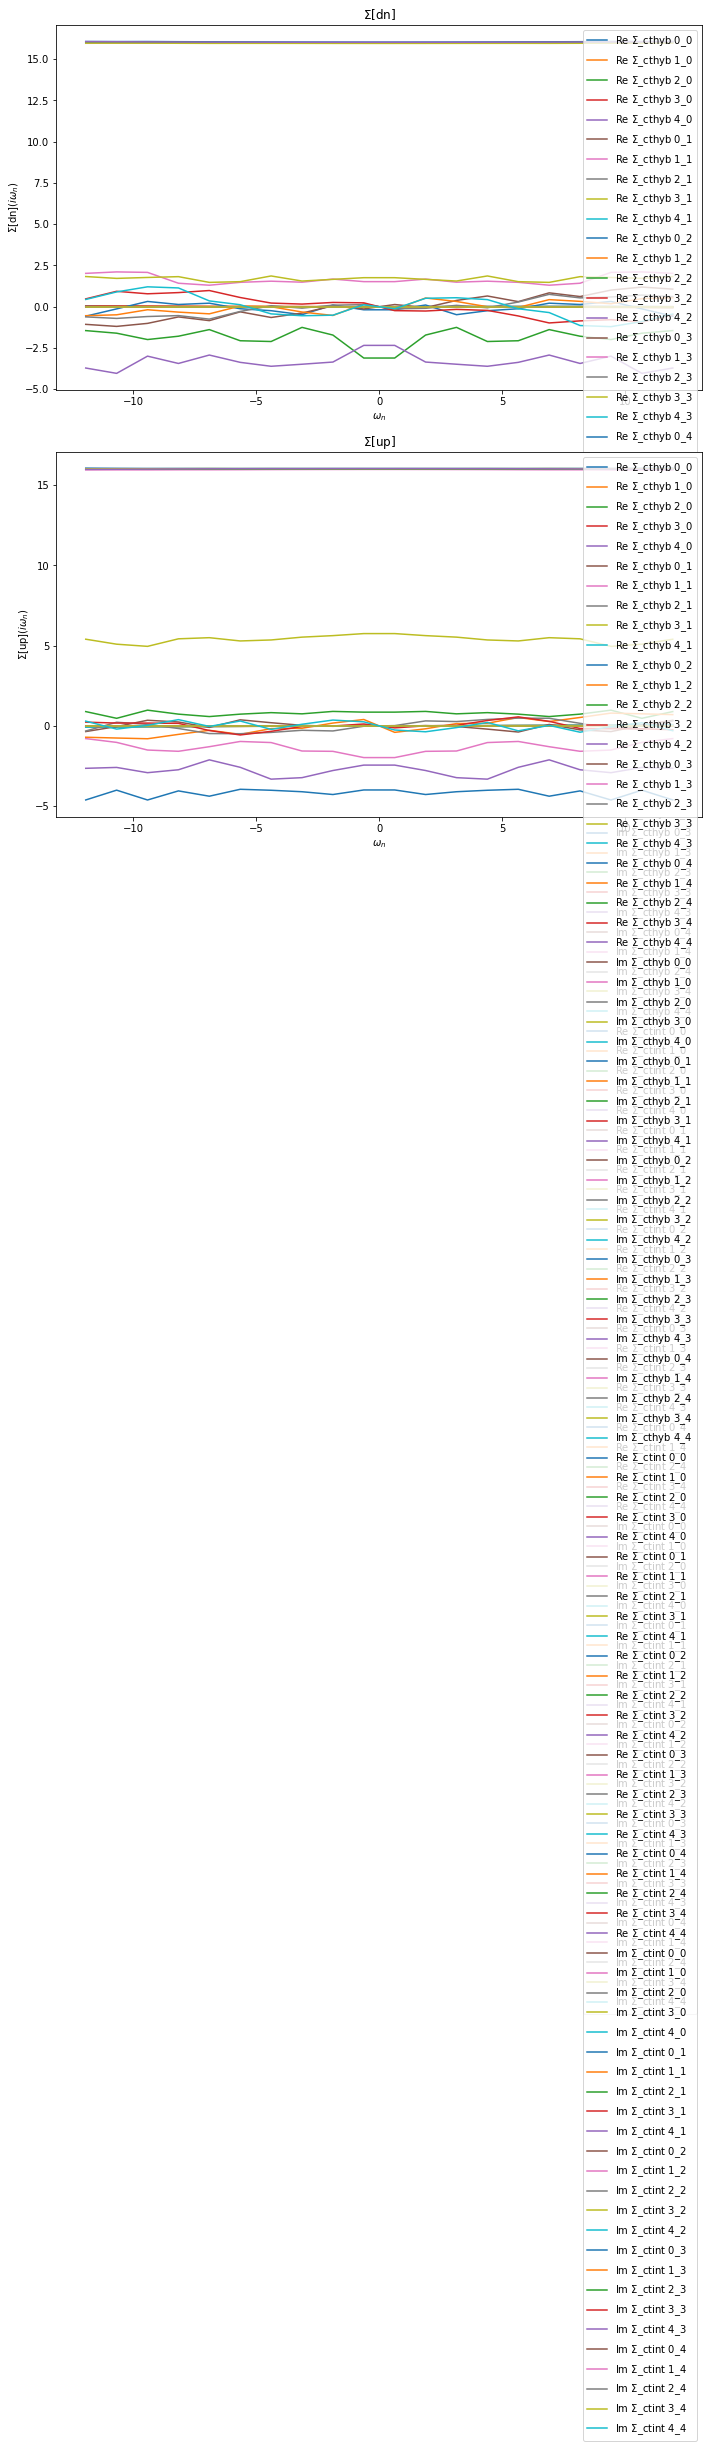

In [3]:
# %load common/plot.py
execfile('model.py')

from pytriqs.archive import HDFArchive
from pytriqs.plot.mpl_interface import oplot, plt
from glob import glob
from os.path import basename

# === Load Green function for every solver and calculate self-energy

solver_lst = [ basename(f).strip('.h5') for f in glob('results/*.h5') ]
G, Sigma = {}, {}

for solver in solver_lst:
    dat = HDFArchive('results/' + solver + '.h5','r')
    G[solver] = dat['G']
    Sigma[solver] = G0_iw.copy()
    Sigma[solver] << inverse(G0_iw) - inverse(G[solver])

# === For every block and solver, plot Green function and Self energy

block_lst = list(G[solver_lst[0]].indices)
n_blocks = len(block_lst)

for g, name in [[G, 'G'], [Sigma, '$\Sigma$']]:

    plt.subplots(n_blocks,1,figsize=(10,6*n_blocks))

    for i, block in enumerate(block_lst,1):
        fig = plt.subplot(n_blocks,1,i)
        fig.set_title(name + "[" + block + "]")
        for solver in solver_lst:
            oplot(g[solver][block], name = name + "_%s" % solver)
        plt.xlabel("$\omega_n$")
        plt.ylabel(name + "[" + block + "]$(i\omega_n)$")

    plt.tight_layout()
    plt.show()


Deviations
======

We present a table containing deviations between the different solvers measured via

$$||G_{\rm Solver_1} - G_{\rm Solver_2}||_\infty$$

In [4]:
import numpy as np

for block in block_lst:
    deviations = [[ np.amax(np.abs(G[s1][block].data - G[s2][block].data)) for s1 in solver_lst ] \
                    for s2 in solver_lst ]
    
    print "\t\t    Deviations for Block " + block
    print "\t\t -----------------------------------"

    row_format ="{:>15}" * (len(solver_lst) + 1)
    print row_format.format("", *solver_lst)
    row_format ="{:>15}" + "{:>15.2E}" * len(solver_lst)
    for solver, row in zip(solver_lst, deviations):
        print row_format.format(solver, *row)
        
    print "\n\n"

		    Deviations for Block dn
		 -----------------------------------
                         cthyb          ctint
          cthyb       0.00E+00       6.85E-02
          ctint       6.85E-02       0.00E+00



		    Deviations for Block up
		 -----------------------------------
                         cthyb          ctint
          cthyb       0.00E+00       6.83E-02
          ctint       6.83E-02       0.00E+00





In [5]:
		    Deviations for Block dn
		 -----------------------------------
                         cthyb          ctint
          cthyb       0.00E+00       7.15E-02
          ctint       7.15E-02       0.00E+00



		    Deviations for Block up
		 -----------------------------------
                         cthyb          ctint
          cthyb       0.00E+00       6.91E-02
          ctint       6.91E-02       0.00E+00




SyntaxError: invalid syntax (<ipython-input-5-f1e93d3795ac>, line 1)